In [16]:
# link do github: https://github.com/themestrre/Metodos-Numericos

# **Nome:** Carlos Eduardo Leite de Oliveira

# **Matricula:** 242104345

# **MÉTODOS NUMÉRICOS EM CIÊNCIAS MECÂNICAS**

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import brentq
from IPython.display import HTML

# Função de Thomas

In [17]:
def thomas_solver(a, b, c, d):
    """
    Resolve sistema tridiagonal Ax = d pelo algoritmo de Thomas
    """
    n = len(b)
    ac, bc, cc, dc = map(np.copy, (a, b, c, d))
    for i in range(1, n):
        m = ac[i-1] / bc[i-1]
        bc[i] -= m * cc[i-1]
        dc[i] -= m * dc[i-1]
    x = np.zeros(n)
    x[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x

# Função para calculo de λ

In [18]:
def compute_lambdas(Bi, n_roots=50):
    """
    Calcula raízes de λ·tan(λ) = Bi para condição convectiva
    """
    roots = []
    m = 1
    while len(roots) < n_roots:
        a = (m-1)*np.pi + 1e-8
        b = (m-0.5)*np.pi - 1e-8
        try:
            root = brentq(lambda lam: lam*np.tan(lam) - Bi, a, b, maxiter=200)
            roots.append(root)
        except ValueError:
            pass
        m += 1
    return np.array(roots)

# Solução Analítica e Numérica (Sem Termos de Geração)

In [19]:
def analytic_theta_profile(x_star, Fo, Bi, n_terms=60):
    """
    Solução analítica adimensional θ(x*,Fo) para condição convectiva
    """
    lambdas = compute_lambdas(Bi, n_roots=n_terms)
    An = 4 * np.sin(lambdas) / (2*lambdas + np.sin(2*lambdas))
    expo = np.exp(- (lambdas**2) * Fo)
    series = np.sum((An * expo)[:, None] * np.cos(np.outer(lambdas, x_star)), axis=0)
    return series

# Parâmetros físicos e numéricos
# Propriedades do UO2
L = 0.005            # m (raio típico do pellet ~5 mm)
k = 2.8              # W/m·K
rho = 10970.0        # kg/m³
Cp = 270.0           # J/kg·K
h = 200.0            # W/m²·K (coeficiente de convecção moderado)
T_inf = 300.0        # K (temperatura do refrigerante)
T_i = 900.0          # K (temperatura inicial do combustível)

# Difusividade e parâmetros
alpha = k / (rho * Cp)
Nx = 81
dx = L / (Nx - 1)
x = np.linspace(0, L, Nx)

Bi_num = h * dx / k
Bi_analytical = h * L / k

t_final = 30.0       # s
dt = 0.01            # s
Nt = int(np.ceil(t_final / dt))
times = np.linspace(0, Nt*dt, Nt+1)

theta = 1.0          # esquema totalmente implícito
Fo_unit = alpha * dt / dx**2
print(f"α = {alpha:.3e} m²/s,  Fo_unit = {Fo_unit:.4f}")

# Inicialização
T = np.ones(Nx) * T_i
T_all = np.zeros((Nt+1, Nx))
T_all[0, :] = T.copy()

# Loop temporal
for n in range(Nt):
    N = Nx
    a = np.zeros(N-1)
    b = np.zeros(N)
    c = np.zeros(N-1)
    rhs = np.zeros(N)

    for i in range(N):
        if i == 0:
            # simetria no centro (∂T/∂x = 0)
            b[i] = 1 + 2 * theta * Fo_unit
            c[i] = -2 * theta * Fo_unit
            rhs[i] = T[i]
        elif i == N-1:
            # condição convectiva
            a[i-1] = -theta * Fo_unit
            b[i] = 1 + theta * Fo_unit * (1 + Bi_num)
            rhs[i] = T[i] + theta * Fo_unit * Bi_num * T_inf
        else:
            a[i-1] = -theta * Fo_unit
            b[i] = 1 + 2 * theta * Fo_unit
            c[i] = -theta * Fo_unit
            rhs[i] = T[i]

    T = thomas_solver(a, b, c, rhs)
    T_all[n+1, :] = T.copy()

α = 9.453e-07 m²/s,  Fo_unit = 2.4201


# Geraçã́o de Resultados

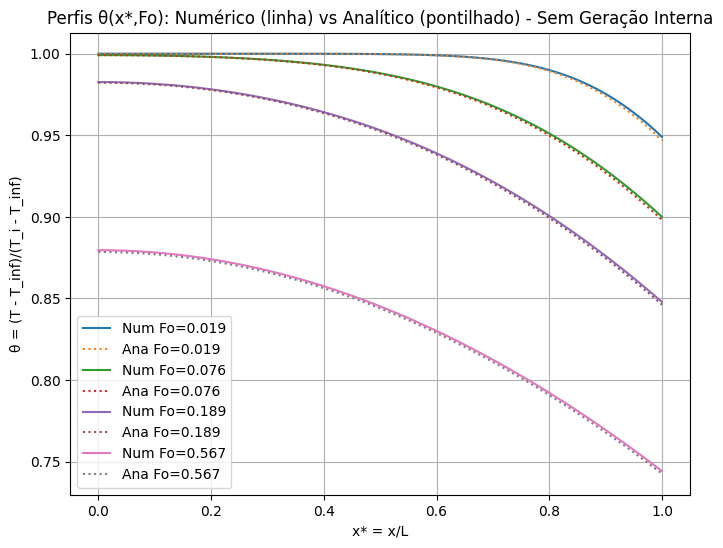

In [20]:
# Comparação analítica θ(x*,Fo)
times_plot = [0.5, 2.0, 5.0, 15.0]
Fo_times = [alpha * t / L**2 for t in times_plot]
x_star = x / L

plt.figure(figsize=(8,6))
for i, tval in enumerate(times_plot):
    idx = int(round(tval / dt))
    Fo_val = alpha * tval / L**2
    theta_num = (T_all[idx,:] - T_inf) / (T_i - T_inf)
    theta_ana = analytic_theta_profile(x_star, Fo_val, Bi_analytical, n_terms=80)
    plt.plot(x_star, theta_num, '-', label=f'Num Fo={Fo_val:.3f}')
    plt.plot(x_star, theta_ana, ':', label=f'Ana Fo={Fo_val:.3f}')
plt.xlabel('x* = x/L')
plt.ylabel('θ = (T - T_inf)/(T_i - T_inf)')
plt.title('Perfis θ(x*,Fo): Numérico (linha) vs Analítico (pontilhado) - Sem Geração Interna')
plt.legend()
plt.grid(True)
plt.show()

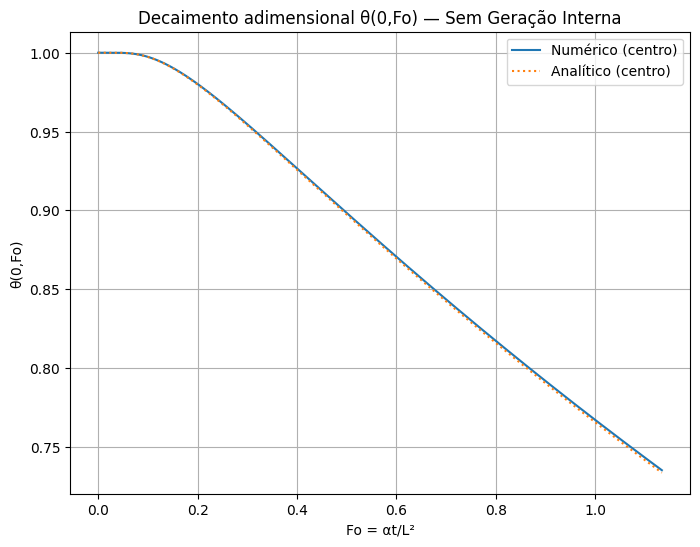

In [21]:
# Comparação θ(0,Fo)
Fo_all = alpha * times / L**2
theta_center = (T_all[:, 0] - T_inf) / (T_i - T_inf)

lambdas = compute_lambdas(Bi_analytical, n_roots=80)
An = 4 * np.sin(lambdas) / (2*lambdas + np.sin(2*lambdas))
theta0_ana = np.zeros_like(Fo_all)
for n in range(len(lambdas)):
    theta0_ana += An[n] * np.exp(-lambdas[n]**2 * Fo_all)

plt.figure(figsize=(8,6))
plt.plot(Fo_all, theta_center, '-', label='Numérico (centro)')
plt.plot(Fo_all, theta0_ana, ':', label='Analítico (centro)')
plt.xlabel('Fo = αt/L²')
plt.ylabel('θ(0,Fo)')
plt.title('Decaimento adimensional θ(0,Fo) — Sem Geração Interna')
plt.legend()
plt.grid(True)
plt.show()

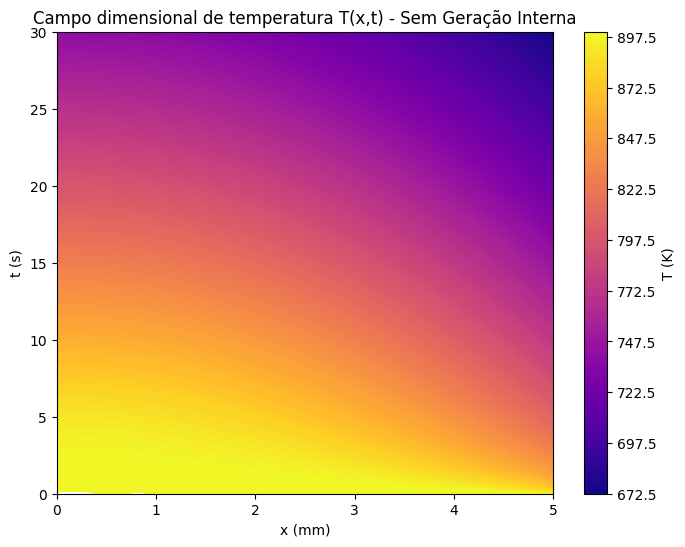

In [22]:
# Mapa de cores θ(x*,Fo)
X_star, Fo_grid = np.meshgrid(x_star, Fo_all)
Theta = (T_all - T_inf) / (T_i - T_inf)

# Mapa de cores T(x,t) dimensional
X_dim, T_dim_grid = np.meshgrid(x, times)
plt.figure(figsize=(8,6))
cp2 = plt.contourf(X_dim*1000, T_dim_grid, T_all, levels=100, cmap='plasma')
plt.colorbar(cp2, label='T (K)')
plt.xlabel('x (mm)')
plt.ylabel('t (s)')
plt.title('Campo dimensional de temperatura T(x,t) - Sem Geração Interna')
plt.show()

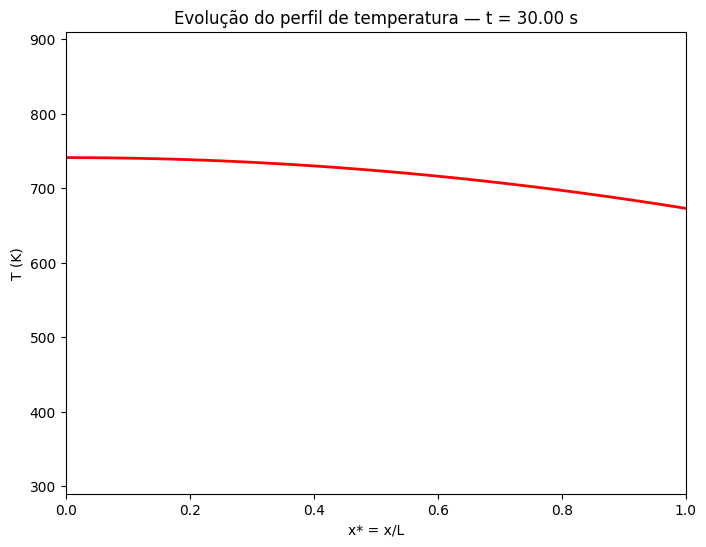

In [23]:
# Animação temporal
fig_anim, ax_anim = plt.subplots(figsize=(8,6))
line_anim, = ax_anim.plot([], [], 'r-', lw=2)
ax_anim.set_xlim(0, 1)
ax_anim.set_ylim((T_inf - 10), (T_i + 10))
ax_anim.set_xlabel('x* = x/L')
ax_anim.set_ylabel('T (K)')
ax_anim.set_title('Evolução do perfil de temperatura')

def init():
    line_anim.set_data([], [])
    return (line_anim,)

def update(frame):
    Tframe = T_all[frame, :]
    line_anim.set_data(x_star, Tframe)
    ax_anim.set_title(f'Evolução do perfil de temperatura — t = {frame*dt:.2f} s')
    return (line_anim,)

anim = FuncAnimation(fig_anim, update, frames=range(0, Nt+1, 50),
                     init_func=init, blit=True, interval=100)

# Exibir no Colab / Jupyter
HTML(anim.to_jshtml())


# CONDUÇÃO TRANSIENTE EM SÓLIDO PLANO COM GERAÇÃO INTERNA (1D)
## Comparação com solução analítica sem geração (para q_dot → 0)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import brentq
from IPython.display import HTML

# Função: Algoritmo de Thomas para resolver sistema tridiagonal
def thomas_solver(a, b, c, d):
    n = len(b)
    ac, bc, cc, dc = map(np.copy, (a, b, c, d))
    for i in range(1, n):
        m = ac[i-1] / bc[i-1]
        bc[i] -= m * cc[i-1]
        dc[i] -= m * dc[i-1]
    x = np.zeros(n)
    x[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x

# Funções auxiliares: autovalores e solução analítica (sem geração)
def compute_lambdas(Bi, n_roots=50):
    roots = []
    m = 1
    while len(roots) < n_roots:
        a = (m-1)*np.pi + 1e-8
        b = (m-0.5)*np.pi - 1e-8
        try:
            root = brentq(lambda lam: lam*np.tan(lam) - Bi, a, b, maxiter=200)
            roots.append(root)
        except ValueError:
            pass
        m += 1
    return np.array(roots)

def analytic_theta_profile(x_star, Fo, Bi, n_terms=60):
    lambdas = compute_lambdas(Bi, n_roots=n_terms)
    An = 4 * np.sin(lambdas) / (2*lambdas + np.sin(2*lambdas))
    expo = np.exp(- (lambdas**2) * Fo)
    series = np.sum((An * expo)[:, None] * np.cos(np.outer(lambdas, x_star)), axis=0)
    return series

# PARÂMETROS FÍSICOS E NUMÉRICOS
L = 0.005           # m (espessura ou raio típico do pellet)
k = 2.8             # W/m·K
rho = 10970.0       # kg/m³
Cp = 270.0          # J/kg·K
h = 200.0           # W/m²·K
T_inf = 300.0       # K
T_i = 900.0         # K

# TERMO DE GERAÇÃO INTERNA (ALTERAR AQUI)
q_dot = 1.0e6       # W/m³  -> use 0.0 para validar limite assintótico

# Propriedades derivadas e parâmetros de malha
alpha = k / (rho * Cp)
Nx = 81
dx = L / (Nx - 1)
x = np.linspace(0, L, Nx)
Bi_num = h * dx / k
Bi_analytical = h * L / k

# Tempo
t_final = 30.0
dt = 0.01
Nt = int(np.ceil(t_final / dt))
times = np.linspace(0, Nt*dt, Nt+1)

# Esquema numérico
theta = 1.0          # totalmente implícito
Fo_unit = alpha * dt / dx**2
print(f"α = {alpha:.3e} m²/s | Fo_unit = {Fo_unit:.6f} | q_dot = {q_dot:.3e} W/m³")

# INICIALIZAÇÃO
T = np.ones(Nx) * T_i
T_all = np.zeros((Nt+1, Nx))
T_all[0, :] = T.copy()

# Termo fonte (incremento de temperatura devido à geração interna)
S_step = dt * q_dot / (rho * Cp)

# LOOP TEMPORAL
for n in range(Nt):
    N = Nx
    a = np.zeros(N-1)
    b = np.zeros(N)
    c = np.zeros(N-1)
    rhs = np.zeros(N)

    for i in range(N):
        if i == 0:
            # condição de simetria no centro (∂T/∂x = 0)
            b[i] = 1 + 2 * theta * Fo_unit
            c[i] = -2 * theta * Fo_unit
            rhs[i] = T[i] + S_step
        elif i == N-1:
            # condição de convecção na superfície
            a[i-1] = -theta * Fo_unit
            b[i] = 1 + theta * Fo_unit * (1 + Bi_num)
            rhs[i] = T[i] + theta * Fo_unit * Bi_num * T_inf + S_step
        else:
            a[i-1] = -theta * Fo_unit
            b[i] = 1 + 2 * theta * Fo_unit
            c[i] = -theta * Fo_unit
            rhs[i] = T[i] + S_step

    T = thomas_solver(a, b, c, rhs)
    T_all[n+1, :] = T.copy()

α = 9.453e-07 m²/s | Fo_unit = 2.420068 | q_dot = 1.000e+06 W/m³


# Geração de Resultados

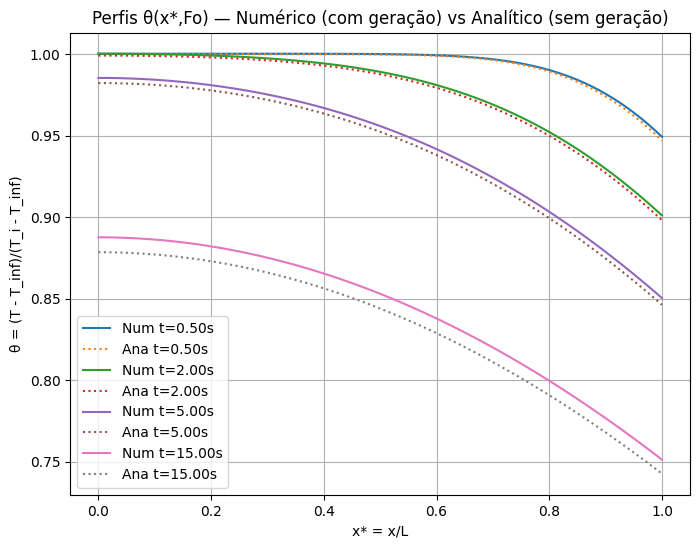

In [25]:
x_star = x / L
times_plot = [0.5, 2.0, 5.0, 15.0]

plt.figure(figsize=(8,6))
for tval in times_plot:
    idx = int(round(tval / dt))
    idx = min(idx, Nt)
    Fo_val = alpha * tval / L**2
    theta_num = (T_all[idx,:] - T_inf) / (T_i - T_inf)
    theta_ana = analytic_theta_profile(x_star, Fo_val, Bi_analytical, n_terms=80)
    plt.plot(x_star, theta_num, '-', label=f'Num t={tval:.2f}s')
    plt.plot(x_star, theta_ana, ':', label=f'Ana t={tval:.2f}s')
plt.xlabel('x* = x/L')
plt.ylabel('θ = (T - T_inf)/(T_i - T_inf)')
plt.title('Perfis θ(x*,Fo) — Numérico (com geração) vs Analítico (sem geração)')
plt.legend()
plt.grid(True)
plt.show()

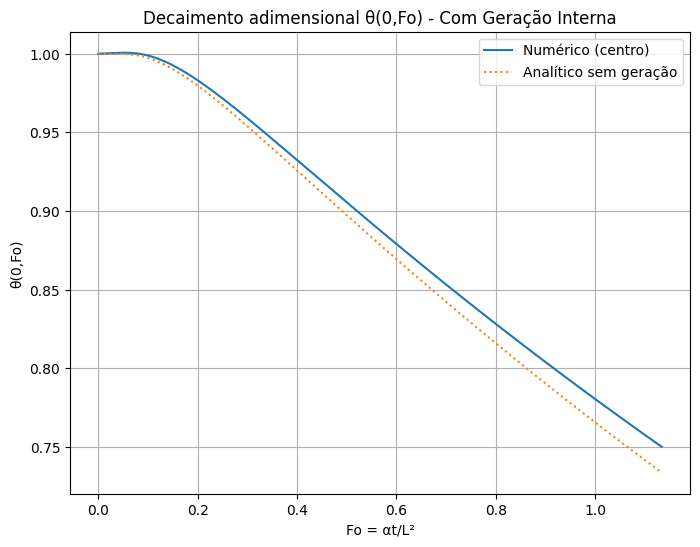

In [28]:
# Evolução temporal no centro
Fo_all = alpha * times / L**2
theta_center = (T_all[:, 0] - T_inf) / (T_i - T_inf)
lambdas = compute_lambdas(Bi_analytical, n_roots=80)
An = 4 * np.sin(lambdas) / (2*lambdas + np.sin(2*lambdas))
theta0_ana = np.zeros_like(Fo_all)
for m in range(len(lambdas)):
    theta0_ana += An[m] * np.exp(-lambdas[m]**2 * Fo_all)

plt.figure(figsize=(8,6))
plt.plot(Fo_all, theta_center, '-', label='Numérico (centro)')
plt.plot(Fo_all, theta0_ana, ':', label='Analítico sem geração')
plt.xlabel('Fo = αt/L²')
plt.ylabel('θ(0,Fo)')
plt.title('Decaimento adimensional θ(0,Fo) - Com Geração Interna')
plt.legend()
plt.grid(True)
plt.show()

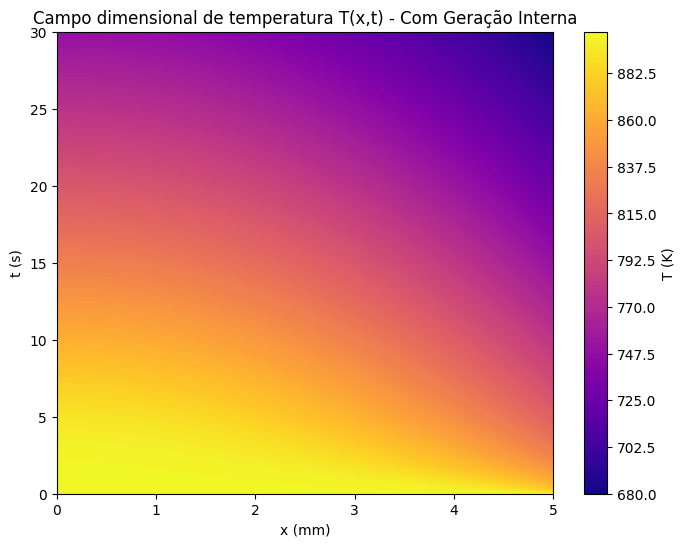

In [29]:
# Campo dimensional T(x,t)
X_dim, T_dim_grid = np.meshgrid(x, times)
plt.figure(figsize=(8,6))
cp2 = plt.contourf(X_dim*1000, T_dim_grid, T_all, levels=100, cmap='plasma')
plt.colorbar(cp2, label='T (K)')
plt.xlabel('x (mm)')
plt.ylabel('t (s)')
plt.title('Campo dimensional de temperatura T(x,t) - Com Geração Interna')
plt.show()

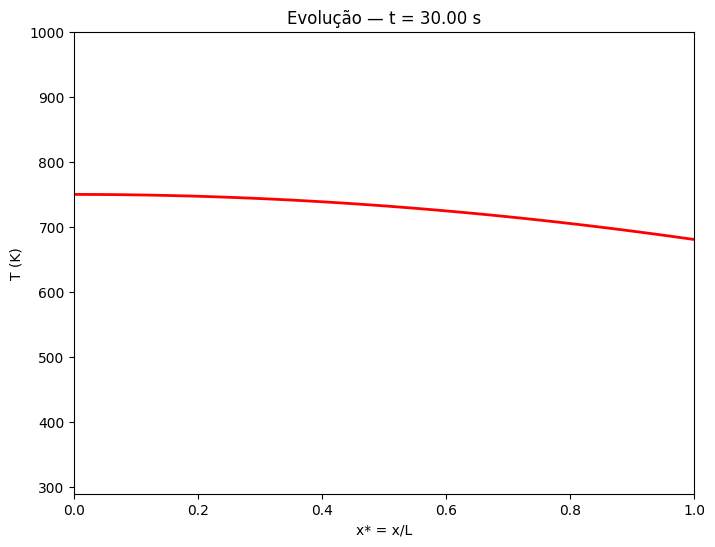

In [30]:
# ANIMAÇÃO TEMPORAL
fig_anim, ax_anim = plt.subplots(figsize=(8,6))
line_anim, = ax_anim.plot([], [], 'r-', lw=2)
ax_anim.set_xlim(0, 1)
ax_anim.set_ylim((T_inf - 10), (T_i + 100))
ax_anim.set_xlabel('x* = x/L')
ax_anim.set_ylabel('T (K)')
ax_anim.set_title('Evolução do perfil de temperatura - Com Geração Interna')

def init():
    line_anim.set_data([], [])
    return (line_anim,)

def update(frame):
    Tframe = T_all[frame, :]
    line_anim.set_data(x_star, Tframe)
    ax_anim.set_title(f'Evolução — t = {frame*dt:.2f} s')
    return (line_anim,)

anim = FuncAnimation(fig_anim, update, frames=range(0, Nt+1, 50),
                     init_func=init, blit=True, interval=100)

HTML(anim.to_jshtml())
